#                                        Logistic Regression

In [31]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import gc

In [55]:
#loading dataset
path = "mnt/ssd/kaggle-talkingdata2/competition_files/"

dtypes = {'ip'           : 'uint32',
          'app'          : 'uint16',
          'device'       : 'uint16',
          'os'           : 'uint16',
          'channel'      : 'uint16',
          'is_attributed': 'uint8' ,
          'click_id'     : 'uint32'
    
         }
print('loading train data...')

train_df = pd.read_csv(path+"train.csv", dtype = dtypes, usecols = ['ip','app','device','os','channel','click_time','is_attributed'])
# total observation : 184,903,891

loading train data...


In [56]:
#Randomly sampling 
train_df_class0 = train_df[train_df['is_attributed']==0]
train_df_class1 = train_df[train_df['is_attributed']==1]
chosen_indexes = np.random.choice(184447044,replace=False,size=456846)
train_df_class0 = train_df_class0.iloc[chosen_indexes]
frames = [train_df_class0,train_df_class1]
train_df = pd.concat(frames)
train_df = train_df.sort_values('click_time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [57]:
gc.collect()


437

In [58]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
103,204158,35,1,13,21,2017-11-06 15:41:07,1
164,182818,3,1,19,379,2017-11-06 15:43:34,0
281,84942,3,1,13,379,2017-11-06 15:49:37,0
428,107922,3,1,19,379,2017-11-06 15:57:30,0
1055,92873,3,1,1,379,2017-11-06 16:00:01,0


In [59]:
print('Extracting day and hour...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day']  = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['min']  = pd.to_datetime(train_df.click_time).dt.minute.astype('uint8')
train_df.drop(['click_time'], axis=1, inplace=True)
y = train_df['is_attributed']

train_df.drop(['is_attributed','ip'], axis=1, inplace=True)

gc.collect()

Extracting day and hour...


28

In [60]:
train_df['app']       =  train_df['app'].astype(str)
train_df['device']    =  train_df['device'].astype(str)
train_df['os']        =  train_df['os'].astype(str)
train_df['channel']   =  train_df['channel'].astype(str)

In [61]:
#One hot encoding of categorical variable
one_hot_encoding = CountVectorizer()
app_one_hot      =  one_hot_encoding.fit_transform(train_df['app'].values)
device_one_hot   =  one_hot_encoding.transform(train_df['device'].values)
os_one_hot       =  one_hot_encoding.transform(train_df['os'].values)
channel_one_hot  =  one_hot_encoding.transform(train_df['channel'].values)


In [62]:
time_df    = train_df[['hour','day','min']]
train_df_1 = hstack((app_one_hot, device_one_hot,os_one_hot) )
train_df   = hstack((train_df_1, channel_one_hot,time_df) )

In [63]:
x_train, x_test, y_train, y_test =train_test_split(train_df, y, test_size=0.2, random_state =99)
x_train, x_cv, y_train, y_cv =train_test_split(x_train, y_train, test_size=0.2, random_state =99)
gc.collect()

70

for alpha = 1e-06


/home/shubham95pandey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


roc Score : 0.8031865272031246
for alpha = 1e-05
roc Score : 0.8315237457670324
for alpha = 0.0001
roc Score : 0.6886699821228168
for alpha = 0.001
roc Score : 0.8288951146945622
for alpha = 0.01
roc Score : 0.8603703726350416
for alpha = 0.1
roc Score : 0.7976666339487188
for alpha = 1
roc Score : 0.6080013222909688
for alpha = 10
roc Score : 0.5378403147821071
for alpha = 100
roc Score : 0.5226146809413047


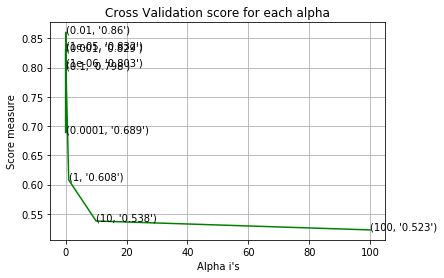

For values of best alpha =  0.01 The roc score is: 0.8603596996991136
For values of best alpha =  0.01 The roc score is: 0.8603703726350416
For values of best alpha =  0.01 The roc score is: 0.860703831926135


In [64]:
#logistic Regression

alpha = [10 ** x for x in range(-6, 3)]
cv_roc_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_cv)
    cv_roc_score_array.append(metrics.roc_auc_score(y_cv, y_predict))
    print("roc Score :",metrics.roc_auc_score(y_cv, y_predict)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_roc_score_array,c='g')
for i, txt in enumerate(np.round(cv_roc_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_roc_score_array[i]))
plt.grid()
plt.title("Cross Validation score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Score measure")
plt.show()


best_alpha = np.argmax(cv_roc_score_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)

y_predict = clf.predict(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The roc score is:",metrics.roc_auc_score(y_train, y_predict))
y_predict = clf.predict(x_cv)
print('For values of best alpha = ', alpha[best_alpha], "The roc score is:",metrics.roc_auc_score(y_cv, y_predict))
y_predict = clf.predict(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The roc score is:",metrics.roc_auc_score(y_test, y_predict))